In [75]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

## This code cleans and transforms raw ONS data into workable geographic data

This code cleans raw ONS energy consumption data through the following steps
- Load raw data in and inspect
- Orignal data contains every UK postal code (1.5m rows). We instead deal with outcodes (2550) rather all 1.5 mn rows of postcode data
- Leverage the *geopy* package to retrieve the latitude and longitude data based on outcodes
- Covert new Latitude_Longitude column into point data and save cleaned and transformed data into new file
- Plot and inspect out new dataset

### 1. Read in Data and inspect it

In [4]:
# read in data
df = pd.read_csv('data/2022_gascon.csv')

# dataset is too large
# cut from specific postcodes to outcode (i.e. N4 2XG > N4) & check
df = df[df['Postcode'] == 'All postcodes']

# clean names
# clean column names function
def clean_column_names(column_name):
    return column_name.strip().replace(' ', '_').lower()
df.columns = [clean_column_names(col) for col in df.columns]

# check
df.head()

,outcode,postcode,num_meters,total_cons_kwh,mean_cons_kwh,median_cons_kwh
0,AB1,All postcodes,157,2.341706e+06,14915.321679,9644.512519
4,AB10,All postcodes,10756,1.267846e+08,11787.339920,9315.654063
471,AB11,All postcodes,9930,9.760425e+07,9829.229976,7679.996322
890,AB12,All postcodes,11072,1.321706e+08,11937.376253,10712.676818
1380,AB13,All postcodes,1204,2.392245e+07,19869.147242,18043.667598


In [5]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2550 entries, 0 to 1108726
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   outcode          2550 non-null   object 
 1   postcode         2550 non-null   object 
 2   num_meters       2550 non-null   int64  
 3   total_cons_kwh   2550 non-null   float64
 4   mean_cons_kwh    2550 non-null   float64
 5   median_cons_kwh  2550 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 139.5+ KB


### The following code uses the *geopy* package to get coordinates using *outcode* column

In [9]:
geolocator = Nominatim(user_agent="geoapiExercises")

# function to get lat / long
def get_lat_lon(outcode):
    try:
        location = geolocator.geocode(f"{outcode}, United Kingdom")
        return (location.latitude, location.longitude)
    except:
        return (None, None)

# avoid hitting rate limits
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# apply to outcode column
df['Latitude_Longitude'] = df['outcode'].apply(lambda x: get_lat_lon(x))

In [11]:
# save df as new csv
df.to_csv('updated_file.csv', index=False)

### 2. Read in *updated_file.csv* & transform into geographic data

In [34]:
df = pd.read_csv('data/updated_file.csv')

In [42]:
# convert string coordinates to a point object
def parse_coordinates(coord_str):
    # strip parentheses
    clean_str = coord_str.strip('()')
    try:
        lat, lon = clean_str.split(',')
        # convert lat / long to float
        return Point(float(lon), float(lat))
    except ValueError:
        # none option
        return None

# apply to 'Latitude_Longitude'
df['geometry'] = df['Latitude_Longitude'].apply(parse_coordinates)

# remove 'None' rows
df = df[df['geometry'].notna()]

# df to gdf
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# WSG 84
gdf.set_crs(epsg=4326, inplace=True)

# save as .gpkg
gdf.to_file('updated_file.gpkg', driver='GPKG')

In [64]:
# load gpkg
gdf = gpd.read_file('data/updated_file.gpkg')

# check it worked
gdf.head()

,outcode,postcode,num_meters,total_cons_kwh,mean_cons_kwh,median_cons_kwh,Latitude_Longitude,geometry
0,AB1,All postcodes,157,2.341706e+06,14915.321679,9644.512519,"(57.1456496, -2.107086)",POINT (-2.10709 57.14565)
1,AB10,All postcodes,10756,1.267846e+08,11787.339920,9315.654063,"(57.1363479, -2.1147281)",POINT (-2.11473 57.13635)
2,AB11,All postcodes,9930,9.760425e+07,9829.229976,7679.996322,"(51.4765615, -0.473901)",POINT (-0.47390 51.47656)
3,AB12,All postcodes,11072,1.321706e+08,11937.376253,10712.676818,"(51.4765368, -0.481525)",POINT (-0.48152 51.47654)
4,AB13,All postcodes,1204,2.392245e+07,19869.147242,18043.667598,"(51.4764944, -0.4904462)",POINT (-0.49045 51.47649)


In [66]:
# drop unneccessary columns
columns_to_drop = ['postcode', 'Latitude_Longitude', 'num_meters']
gdf = gdf.drop(columns=columns_to_drop)
# check
gdf.head()

,outcode,total_cons_kwh,mean_cons_kwh,median_cons_kwh,geometry
0,AB1,2.341706e+06,14915.321679,9644.512519,POINT (-2.10709 57.14565)
1,AB10,1.267846e+08,11787.339920,9315.654063,POINT (-2.11473 57.13635)
2,AB11,9.760425e+07,9829.229976,7679.996322,POINT (-0.47390 51.47656)
3,AB12,1.321706e+08,11937.376253,10712.676818,POINT (-0.48152 51.47654)
4,AB13,2.392245e+07,19869.147242,18043.667598,POINT (-0.49045 51.47649)


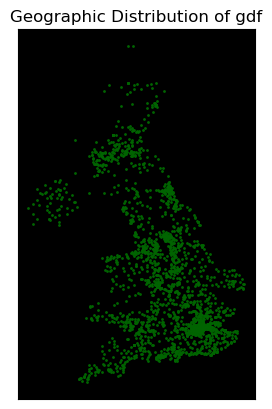

In [85]:
# plot data
# aesthetics
ax = gdf.plot(color='darkgreen', markersize=1)

# background, remove axis labels & title
ax.set_facecolor('black')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Geographic Distribution of gdf')

# plot
plt.show()